## 1. Изучение данных

Импорт требуемых библиотек.

In [1]:
#processing
import pandas as pd
import numpy as np

#prediction
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

#warning
import warnings
warnings.simplefilter('ignore')

Импорт и анализ данных.

Создаем dataframe 'tariffs', импортируем в него требуемый датасет и анализируем исходные данные.

In [2]:
tariffs = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
display(tariffs.info())
display(tariffs.shape)
display(tariffs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

(3214, 5)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Несмотря на утверждение, что предобработка данных не требуется, я предлагаю перевести количество звонков и смс в значение 'int', не может быть "неполных" звонков.

In [4]:
tariffs['calls'] = tariffs['calls'].astype('int')
tariffs['messages'] = tariffs['messages'].astype('int')

tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null int64
minutes     3214 non-null float64
messages    3214 non-null int64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


### Вывод
Исходный датасет состоит из 3214 строк и 5 столбцов, не содержит пропущенных значений.  
В процессе предобработки данные приведены к более удобноми типу, переходим к дальнейшему исследованию.

---

## 2. Разбитие данных на выборки

При отсутствии наличия спятанной тестововой выборки, используя метод train_test_split, разобъем исходный датасет на 3 выборки, train, valid и test, в соотношении 60/20/20 % от общих данных, соответственно.

In [5]:
df_train, df_temp = train_test_split(tariffs, test_size=0.4, random_state=555)

df_valid, df_test = train_test_split(df_temp, test_size=0.5, random_state=555)

In [6]:
df_train.shape[0], df_valid.shape[0], df_test.shape[0]

(1928, 643, 643)

Проверка выборок завершилась успешно.  

---

Выделяем признаки (features) и целевой признак(target) в каждой выборке.  
Целевым признаком становятся значения столбца 'is_ultra', признаками - значения всех остальных столбцов.

In [7]:
features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

В нашем кейсе необходимо решить задачу бинарной классификации - определить какой из двух тарифов {'smart' : 0, 'ultra' : 1} необходимо предложить клиентам на основании их текущего потребления услуг.  
Определив требуемый вид моделей переходим к исследованиям.

### Вывод

На втором этапе произведена разбивка датасета на выборки, определен требуемый тип моделей - классификация.

---

## 3. Исследование моделей

#### 1. Дерево решений (Decision Tree Classifier)

Создадим функцию для проверки различного значения глубины деревьев в диапазоне от 1 до 10. Выберем наилучшее значение accuracy из получившегося списка. Значения accuracy проверяем на валидационной выборке.

In [8]:
for depth in range(1,11):    
    
    model_dtc = DecisionTreeClassifier(random_state=555, max_depth=depth)
    model_dtc.fit(features_train, target_train)

    prediction_valid = model_dtc.predict(features_valid)
    
    print('max_depth =', depth, end=', ')
    print('accuracy =', accuracy_score(target_valid, prediction_valid))

max_depth = 1, accuracy = 0.7511664074650077
max_depth = 2, accuracy = 0.7651632970451011
max_depth = 3, accuracy = 0.776049766718507
max_depth = 4, accuracy = 0.7651632970451011
max_depth = 5, accuracy = 0.7216174183514774
max_depth = 6, accuracy = 0.776049766718507
max_depth = 7, accuracy = 0.776049766718507
max_depth = 8, accuracy = 0.776049766718507
max_depth = 9, accuracy = 0.7744945567651633
max_depth = 10, accuracy = 0.7729393468118196


Наилучшее значение показали модели с "глубиной деревьев" = 3 и [6:8] (accuracy ~0.776). Для ускорения вычислений принимаем параметр max_depth = 3 за наилучший.

---

#### 2. Случайный лес (Random Forest Classifier)

Напишем функцию для проверки значений accuracy при увеличении числа деревьев  1 до 10). 

In [9]:
for es in range(1, 101, 5):
    
        model_rfs = RandomForestClassifier(random_state=555, n_estimators=es)
    
        model_rfs.fit(features_train, target_train)

        prediction_valid = model_rfs.predict(features_valid)
    
        print('n_estimators =', es, end=', ')
        print('accuracy =', accuracy_score(target_valid, prediction_valid))

n_estimators = 1, accuracy = 0.713841368584759
n_estimators = 6, accuracy = 0.76049766718507
n_estimators = 11, accuracy = 0.7636080870917574
n_estimators = 16, accuracy = 0.7791601866251944
n_estimators = 21, accuracy = 0.7667185069984448
n_estimators = 26, accuracy = 0.7838258164852255
n_estimators = 31, accuracy = 0.776049766718507
n_estimators = 36, accuracy = 0.7838258164852255
n_estimators = 41, accuracy = 0.776049766718507
n_estimators = 46, accuracy = 0.7791601866251944
n_estimators = 51, accuracy = 0.7713841368584758
n_estimators = 56, accuracy = 0.7744945567651633
n_estimators = 61, accuracy = 0.7682737169517885
n_estimators = 66, accuracy = 0.776049766718507
n_estimators = 71, accuracy = 0.776049766718507
n_estimators = 76, accuracy = 0.7776049766718507
n_estimators = 81, accuracy = 0.776049766718507
n_estimators = 86, accuracy = 0.7807153965785381
n_estimators = 91, accuracy = 0.776049766718507
n_estimators = 96, accuracy = 0.7776049766718507


Наилучший показатель accuracy достигается при количестве деревьев = 30 (accuracy ~0.784). Посмотрим, изменятся ли значения при увеличении "глубины деревьев".

* На данном шаге я тестировал различные варианты, самые качественные получились при значениях 26 и 30. Решено было оставить вариант 30, который показывал лучшие значения при тестировании значений глубины деревьев.

In [10]:
for depth in range(1,11):
    
    model_rfs = RandomForestClassifier(random_state=555, n_estimators=30, max_depth=depth)
    
    model_rfs.fit(features_train, target_train)

    prediction_valid = model_rfs.predict(features_valid)
    
    print('max_depth =', depth, end=', ')
    print('accuracy =', accuracy_score(target_valid, prediction_valid))
   

max_depth = 1, accuracy = 0.7216174183514774
max_depth = 2, accuracy = 0.7620528771384136
max_depth = 3, accuracy = 0.776049766718507
max_depth = 4, accuracy = 0.7822706065318819
max_depth = 5, accuracy = 0.7900466562986003
max_depth = 6, accuracy = 0.7931570762052877
max_depth = 7, accuracy = 0.7916018662519441
max_depth = 8, accuracy = 0.7916018662519441
max_depth = 9, accuracy = 0.7838258164852255
max_depth = 10, accuracy = 0.7869362363919129


В ходе представленного анализа выявлены лучшие гиперпараметры для модели случайного леса: n_estimators=30, max_depth=8 (accuracy ~0.792). Принимаем их, как основные в финальной модели.

---

#### На момент текущего проекта не знал про возможноcти пайплайнов и пойсков параметров кросс-валидацией.

1. Про вложенный список думал в процессе работы над проектом, но не хотел выдавать длинные списки. Думал, как решить задачу, но ничего в голову не приходило.   
2. В итоге - решил создать dataframe под именем temp, в который будут добавляться полученные значения и в конце выводиться строка с наилучшим показанием accuracy score на валидационной выборке.  
3. В качестве еще одного доп. параметра вложил в функцию перебор значений min_samples_split в диапазоне 2-4, для отработки навыка и для улучшения модели.

Посмотрим как будет работать.

In [11]:
%%time

d = {'n_est':[], 
     'max_d':[], 
     'acc_tr':[], 
     'min_s_s':[],
     'acc_val':[]
    }

temp = pd.DataFrame(d)

a = -1

for es in range(1, 101, 10):
    for depth in range(1,10):
        for samp_split in range(2, 5):
        
            a+=1
        
            model_rfs = (
                RandomForestClassifier
                (random_state=555, n_estimators=es, max_depth=depth, min_samples_split=samp_split)
            )
    
            model_rfs.fit(features_train, target_train)

            prediction_train = model_rfs.predict(features_train)
            prediction_valid = model_rfs.predict(features_valid)
    
            #print('n_estimators =', es, end=', ')
            #print('max_depth =', depth, end=', ')
            #print('accuracy train =', accuracy_score(target_train, prediction_train), end=', ')
            #print('accuracy valid =', accuracy_score(target_valid, prediction_valid))
            temp.loc[a, 'n_est'] = es
            temp.loc[a, 'max_d'] = depth
            temp.loc[a, 'min_s_s'] = samp_split
            temp.loc[a, 'acc_tr'] = accuracy_score(target_train, prediction_train)
            temp.loc[a, 'acc_val'] = accuracy_score(target_valid, prediction_valid)
        
temp.sort_values(by='acc_val', ascending=False).head(1)

CPU times: user 47.5 s, sys: 300 ms, total: 47.8 s
Wall time: 47.8 s


,n_est,max_d,acc_tr,min_s_s,acc_val
152,51.0,6.0,0.841805,4.0,0.797823


42 секунды ожидания показали, что удалось достичь значения accuracy на валидационной выборке ~0.798, против ~0.792 с предыдущими параметрами.

Как итог - в обновленную модель внесем гиперпараметры, представленные выше.

---

#### 3. Логистическая регрессия (Logistic Regression)

Рассчитаем значение accuracy модели логистической регрессии на валидационной выборке, указав параметр алгоритма регрессии (solver) = 'lbfgs'.

In [12]:
model_lr = LogisticRegression(random_state=555, solver='lbfgs')

model_lr.fit(features_train, target_train)

#prediction_valid = model_lr.predict(features_valid)

print('accuracy =', model_lr.score(features_valid, target_valid))

accuracy = 0.7309486780715396


Данная модель демонстрирует наименьшие значение accuracy из всех представленных моделей (~0.73).

---

#### 4. Выбор наилучшей модели

Полученные в предыдущих шагах данные позволяют создать модель с наибольшим показателем "правильности" (accuracy).  
Ниже привожу все параметры выбранной модели.

1. Тип модели - Random Forest Classifier
2. Значение n-estimates = 30  
3. Значение max_depth = 6  

Создаем рабочую модель и обучаем ее на всем исходном датасете.  
Для этого выделяем значения параметров и целевого параметра непосредственно из фрейма tariffs.

In [13]:
features_final = tariffs.drop(['is_ultra'], axis=1)
target_final = tariffs['is_ultra']

In [14]:
model_final = RandomForestClassifier(random_state=555, n_estimators=30, max_depth=8)
model_final.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=555,
                       verbose=0, warm_start=False)

In [15]:
model_final_upd = RandomForestClassifier(random_state=555, n_estimators=51, max_depth=6, min_samples_split=4)
model_final_upd.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=6, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=51,
                       n_jobs=None, oob_score=False, random_state=555,
                       verbose=0, warm_start=False)

### Вывод

На данном шаге были протестированы три возможные модели классификации.  
Сравнение лучших значений accuracy и гиперпараметров, полученных на валидационной выборке, представленно ниже:

1. Decision Tree Classifier : accuracy ~0.776, max_depth = 3  
2. Random Forest Classifier : accuracy ~0.798, n_estimators = 51, max_depth = 6, min_sample_split=4  
3. Logistic Regression : accuracy ~0.73

На основании полученных результатов выявлена и построена самая удачная модель: Random Forest Classifier, обученная на полном датасете tariffs.

---

## 4. Проверка модели на тестовой выборке

Проверяем модель, обученную на полном датасете, на тестовой выборке.

In [16]:
model_final.score(features_test, target_test)

0.8304821150855366

In [17]:
model_final_upd.score(features_test, target_test)

0.8258164852255054

Достаточно высокий показатель accuracy (~0.87).  -- ~0.83 на обновленной модели 
Однако проверим, какой результат покажет модель, обученная только на выборке train. 

Проверим модель на точность и полноту на тестовой выборке.  
Импортируем требуемые библиотеки.

In [18]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Выводим предсказанные значения тарифов на тестовой выборке.

In [19]:
prediction_test = model_final_upd.predict(features_test)

Проверяем точность модели

In [20]:
print('Точность модели (precision score): {0:0.2f}'.format(precision_score(prediction_test, target_test, average='macro')))

Точность модели (precision score): 0.74


Проверяем полноту моделей

In [21]:
print('Полнота модели (recall score): {0:0.2f}'.format(recall_score(prediction_test, target_test, average='macro')))

Полнота модели (recall score): 0.82


In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [34]:
confusion_matrix = confusion_matrix(target_test, prediction_test)
print(confusion_matrix)

[[433  24]
 [ 88  98]]


In [38]:
print(classification_report(target_test, prediction_test))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89       457
           1       0.80      0.53      0.64       186

    accuracy                           0.83       643
   macro avg       0.82      0.74      0.76       643
weighted avg       0.82      0.83      0.81       643



In [41]:
import matplotlib.pyplot as plt

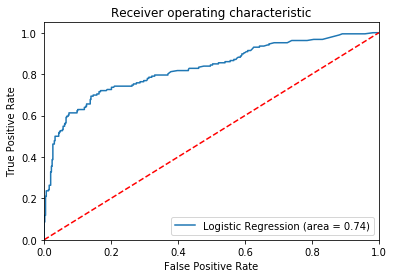

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(target_test, model_final_upd.predict(features_test))
fpr, tpr, thresholds = roc_curve(target_test, model_final_upd.predict_proba(features_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Вывод  

Полученная модель продемонстрировала значение accuracy ~ 0.85, что является достаточно хорошим показателем и означает, что доля правильных прогнозов тарифа равняется 85%. Дополнительно стоит отметить, что показатели точности и полноты приведенной модели составляют 79 и 90 пунктов соответственно, что говорит о достаточно высокой способности предсказывать действительно верные показатели.

---

## 5. (бонус) Проверка модели на адекватность

С этим вопросом пока непонятно, из курса статистики на stepike узнал, что чем меньше значение R-sqr - тем модель лучше / адекванее. Хотя там дело касалось регрессии, возможно, можно данный метод применить и в классификации.

In [22]:
import statsmodels.formula.api as smf

In [23]:
lm = smf.ols(formula='is_ultra ~ calls + minutes + messages + mb_used', data=tariffs).fit()

lm.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               is_ultra   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     76.14
Date:                Sun, 22 Mar 2020   Prob (F-statistic):           9.19e-62
Time:                        13:00:02   Log-Likelihood:                -1926.2
No. Observations:                3214   AIC:                             3862.
Df Residuals:                    3209   BIC:                             3893.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0278      0.022     -1.256      0.209      -0.071       0.016
calls          0.0005      0.001      0.440      0.660      -0.002       0.003
minutes        0.0002      0.000      1.181      0.238      -0.000       0.001
messages       0.0020      0.000      8.852      0.000       0.002       0.002
mb_used     7.764e-06   1.09e-06      7.154      0.000    5.64e-06    9.89e-06
==============================================================================
Omnibus:                      765.682   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              498.325
Skew:                           0.849   Prob(JB):                    6.17e-109
Kurtosis:                       2.085   Cond. No.                     5.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Как видно - значение R-square очень близко к нулю, а это значит, что модель рабочая (наверное)

Еще, как вариант, вычитал про проверку MAE - чем ближе к нулю - тем лучше модель

In [24]:
from sklearn.metrics import mean_absolute_error

In [25]:
mean_absolute_error(target_test, prediction_test)

0.17418351477449456

Среднее абсолютной погрешности ~0.17, что является показателем высокого качества моделя

---

Если выводы не верны - прошу не кидаться шапками, я пока только познаю статистику.

### Вывод

Несмотря на неуверенность в приведенных методах проверки адекватности выборки, полученные показатели демонстрируют высокое качество и адекватность модели.

---

#### Исправлено

1. Насколько я понял, модель, всегда предсказывающая тариф ультра должна обучиться на данных, где target = 1.  
Тогда проводим следующие преобразования:

In [26]:
target_train_upd = target_train.replace(0,1)
target_train_upd.unique()

array([1])

In [27]:
model_test = RandomForestClassifier(random_state=555, n_estimators=51, max_depth=6, min_samples_split=4)

model_test.fit(features_train, target_train_upd)

prediction_test_1 = model_test.predict(features_test)

In [31]:
print('Правильность тестовой модели: {0:0.2f}'.format(model_test.score(features_test, target_test)))
print('Точность тестовой модели: {0:0.2f}'.format(precision_score(prediction_test_1, target_test, average='macro')))
print('Полнота модели: {0:0.2f}'.format(recall_score(prediction_test_1, target_test, average='macro')))

Правильность тестовой модели: 0.29
Точность тестовой модели: 0.50
Полнота модели: 0.14


Как видно, ультра-модель демонтстрирует очень плохие показатели.

---

2. Dummy Classifier

Импортируем "подставное лицо"

In [28]:
from sklearn.dummy import DummyClassifier

Обучаем новые модели

In [29]:
dummy_model_1 = DummyClassifier(strategy="most_frequent", random_state=555)
dummy_model_2 = DummyClassifier(strategy="constant", constant=1, random_state=555)

dummy_model_1.fit(features_train, target_train)
dummy_model_2.fit(features_train, target_train)

DummyClassifier(constant=1, random_state=555, strategy='constant')

Тестируем подставные модели.

In [30]:
print('Accuracy модели со стратегией "most_frequent" = {0:0.2f}'.format(dummy_model_1.score(features_test, target_test)))
print('Accuracy модели со стратегией "constant" со значением 1 = {0:0.2f}'.format(dummy_model_2.score(features_test, target_test)))

Accuracy модели со стратегией "most_frequent" = 0.71
Accuracy модели со стратегией "constant" со значением 1 = 0.29


А первая стратегия могла бы сойти на нормальную модель. Но модель со значениями только "1" - продемонстрирвала адекватность настоящей модели.

### Вывод обновленный

Удалось доказать, что первая построенная модель работает адекватно.

---

## Общий вывод

В процессе исследования моделей, предсказывающих предложение определенного тарифа для конечного пользователя по имеющимся данным, были выявлены следующие особенности:

1. В данном проекте необходимо было решить задачу классификации;
2. Для обучения моделей первичный датасет был разбит на три выборки (60/20/20%);
3. Значение метода accuracy рассчитывалось по валидационной выборке;
4. Наилучшие результаты показателя accuracy продемонтсрировала модель Random Fortress Classifier;
5. Наихудшие результаты accuracy у модели Logistic Regression;
6. За основную модель была принята модель "случайного леса" со значениями n_estimators=51, max_depth=6, min_samples_split=4;
7. Обученная на полном датасете тестовая модель продемонстрировала accuracy ~0.83. В обоих случаях выведена "правильность" больше, чем минимальная требуемая в проекте.  
8. Показатели точности и полноты финальной модели составляют 74 и 82 пунктов соответственно.  
9. Проведена оценка модели на вменяемость, исследован метод DummyClassifier

*Целью проекта* было создание рабочей модели.  
Пункты 7 и 8 позволяют утверждать, что обученная модель удовлетворят требованиям проекта и может быть применена при прогнозировании предложения тарифа связи для определенного пользователя.

*Задачами проекта* выступали отработка построения различных моделей.  
С моделями классификации все вопросы были решены. Регрессионные модели, вероятно, будут применяться в следующих проектах.

Итог - цели и задачи текущего проекта выполнены.

---